In [1]:
# Normalize /mnt/data/HR_policy.jsonl -> /content/qa_clean_hr.jsonl
# Supports {"user","assistant"} OR {"messages":[{"role":"user|assistant","content":...}, ...]}

import json, re
from collections import Counter
from pathlib import Path

IN_JSONL  = "/content/HR_policy.jsonl"   # <- change if needed
OUT_JSONL = "/content/qa_clean_hr.jsonl"
Path(OUT_JSONL).parent.mkdir(parents=True, exist_ok=True)

def get_from_messages(obj):
    msgs = obj.get("messages")
    if not isinstance(msgs, list) or not msgs:
        return None, None
    # last user + first assistant after it
    user_text = None
    for m in reversed(msgs):
        if isinstance(m, dict) and m.get("role","").lower() == "user":
            user_text = str(m.get("content","")).strip()
            break
    if not user_text:
        return None, None
    seen_user = False
    for m in msgs:
        if isinstance(m, dict) and m.get("role","").lower() == "user" and str(m.get("content","")).strip() == user_text:
            seen_user = True
            continue
        if seen_user and isinstance(m, dict) and m.get("role","").lower() == "assistant":
            return user_text, str(m.get("content","")).strip()
    return user_text, None

def extract_qa(obj):
    # 1) messages schema
    u, a = get_from_messages(obj)
    if u and a: return u, a
    # 2) direct key variants
    for uk, ak in [
        ("user","assistant"), ("question","answer"),
        ("input","output"), ("prompt","response"),
        ("instruction","output"), ("human","bot"),
        ("User","Assistant")
    ]:
        u = str(obj.get(uk,"") or "").strip()
        a = str(obj.get(ak,"") or "").strip()
        if u and a: return u, a
    # 3) free-text tagged
    t = str(obj.get("text","") or "").strip()
    if t:
        m = re.search(r"User:\s*(.+?)\s*Assistant:\s*(.+)", t, flags=re.S|re.I)
        if m: return m.group(1).strip(), m.group(2).strip()
    return None, None

pairs, key_counter = [], Counter()
with open(IN_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line: continue
        try:
            obj = json.loads(line)
        except Exception:
            continue
        key_counter.update(obj.keys())
        u, a = extract_qa(obj)
        if u and a:
            pairs.append({"prompt": f"User: {u}\nAssistant:", "completion": a})

print("Top keys seen:", key_counter.most_common(20))
print("Valid pairs:", len(pairs))
if not pairs:
    raise ValueError("No Q/A pairs found. Please show a couple of raw lines so we can adjust the parser.")

with open(OUT_JSONL, "w", encoding="utf-8") as w:
    for r in pairs:
        w.write(json.dumps(r, ensure_ascii=False) + "\n")

print("Wrote cleaned JSONL to:", OUT_JSONL)


Top keys seen: [('messages', 644)]
Valid pairs: 644
Wrote cleaned JSONL to: /content/qa_clean_hr.jsonl


In [3]:
# LoRA SFT for HR policy Q&A — plain Transformers + PEFT (version-friendly)

!pip -q install "transformers>=4.31.0" "datasets>=2.14.0" "peft>=0.6.0" accelerate

import random
from dataclasses import dataclass
from typing import List, Dict
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)

DATA_JSONL = "/content/qa_clean_hr.jsonl"    # from step 1
MODEL_NAME = "facebook/opt-350m"             # start small; you can switch to opt-1.3b later
OUTPUT_DIR = "/content/hr_lora_out"
MAX_LEN = 1024
BATCH = 2
EPOCHS = 5
LR = 2e-4

# --- Load & split ---
ds = load_dataset("json", data_files=DATA_JSONL, split="train")
splits = ds.train_test_split(test_size=0.1, seed=SEED)
train_ds, val_ds = splits["train"], splits["test"]

# --- Tokenizer & base ---
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# --- Apply LoRA (OPT-style) ---
lora_cfg = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05, bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","out_proj","fc1","fc2"]
)
model = get_peft_model(base, lora_cfg)

# --- Dataset: mask prompt so loss is only on completion ---
class ChatDataset(Dataset):
    def __init__(self, hf_split, tokenizer: AutoTokenizer, max_len: int):
        self.data = hf_split; self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        prompt = ex["prompt"]         # "User: ...\nAssistant:"
        completion = ex["completion"] # assistant answer
        prompt_ids = self.tok(prompt, add_special_tokens=False)["input_ids"]
        completion_ids = self.tok(" " + completion, add_special_tokens=False)["input_ids"]
        input_ids = prompt_ids + completion_ids + [self.tok.eos_token_id]
        labels    = [-100]*len(prompt_ids) + completion_ids + [self.tok.eos_token_id]
        if len(input_ids) > self.max_len:
            input_ids = input_ids[-self.max_len:]
            labels    = labels[-self.max_len:]
        attention_mask = [1]*len(input_ids)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

train_torch = ChatDataset(train_ds, tok, MAX_LEN)
val_torch   = ChatDataset(val_ds, tok, MAX_LEN)

# --- Simple padding collator ---
@dataclass
class PadCollator:
    pad_id: int
    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        maxlen = max(x["input_ids"].size(0) for x in batch)
        def pad_vec(v, pad_val):
            pad_len = maxlen - v.size(0)
            return torch.cat([v, torch.full((pad_len,), pad_val, dtype=v.dtype)], dim=0) if pad_len>0 else v
        input_ids = torch.stack([pad_vec(x["input_ids"], self.pad_id) for x in batch])
        attention = torch.stack([pad_vec(x["attention_mask"], 0) for x in batch])
        labels    = torch.stack([pad_vec(x["labels"], -100) for x in batch])
        return {"input_ids": input_ids, "attention_mask": attention, "labels": labels}

collator = PadCollator(pad_id=tok.pad_token_id)

# --- Train (no evaluation_strategy) ---
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=1,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=collator,
    train_dataset=train_torch,
    eval_dataset=val_torch,  # we’ll evaluate manually after training
)

trainer.train()
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

# --- Save adapters & tokenizer ---
trainer.model.save_pretrained(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print("Saved LoRA adapters to:", OUTPUT_DIR)

# --- Inference helper ---
from peft import PeftModel
def hr_chat(user_text, max_new_tokens=200, mode="greedy"):
    base = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
    peft = PeftModel.from_pretrained(base, OUTPUT_DIR).eval()
    system_hint = ("You are an HR information assistant. Provide general policy info, "
                   "not legal advice. Refer to HR best practices and encourage checking company policy.\n")
    prompt = f"{system_hint}User: {user_text}\nAssistant:"
    inputs = tok(prompt, return_tensors="pt").to(peft.device)
    gen_kwargs = dict(max_new_tokens=max_new_tokens)
    if mode == "greedy":
        gen_kwargs.update(dict(do_sample=False))
    else:
        gen_kwargs.update(dict(do_sample=True, temperature=0.7, top_p=0.9))
    with torch.no_grad():
        out = peft.generate(**inputs, **gen_kwargs)
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split("Assistant:")[-1].strip()

print(hr_chat("What’s a typical PTO policy structure?", mode="topp"))


RuntimeError: THPDtypeType.tp_dict == nullptr INTERNAL ASSERT FAILED at "/pytorch/torch/csrc/Dtype.cpp":177, please report a bug to PyTorch. 

In [2]:
!pip uninstall -y torch torchvision torchaudio xformers
!pip cache purge

# GPU version (CUDA 12.1, typical for Colab)
!pip install --index-url https://download.pytorch.org/whl/cu121 \
  torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1

# Optional (speedups on some GPUs)
!pip install xformers==0.0.27.post2


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Files removed: 0
Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.9/798.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch, torchvision, torchaudio, platform
print("PyTorch:", torch.__version__)
print("TorchVision:", torchvision.__version__)
print("TorchAudio:", torchaudio.__version__)
print("Python:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())


PyTorch: 2.4.0+cu121
TorchVision: 0.19.1+cu121
TorchAudio: 2.4.1+cu121
Python: 3.12.11
CUDA available: True


In [2]:
# LoRA SFT for HR Q&A — plain Transformers + PEFT (version-friendly; safetensors base)

import random, os
from dataclasses import dataclass
from typing import List, Dict
import torch
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, PeftModel

SEED = 42
random.seed(SEED); torch.manual_seed(SEED)

DATA_JSONL = "/content/qa_clean_hr.jsonl"    # from step 1
MODEL_NAME = "facebook/opt-1.3b"             # ships safetensors (avoids torch<2.6 restriction)
OUTPUT_DIR = "/content/hr_lora_out"
MAX_LEN = 1024
BATCH = 2
EPOCHS = 5
LR = 2e-4

# --- Load & split ---
ds = load_dataset("json", data_files=DATA_JSONL, split="train")
splits = ds.train_test_split(test_size=0.1, seed=SEED)
train_ds, val_ds = splits["train"], splits["test"]
print("Train/Val sizes:", len(train_ds), len(val_ds))

# --- Tokenizer & base ---
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

# Force safetensors load to avoid CVE guard on torch<2.6
base = AutoModelForCausalLM.from_pretrained(MODEL_NAME, use_safetensors=True)

# --- Apply LoRA (OPT-style targets; adjust if you change base arch) ---
lora_cfg = LoraConfig(
    r=16, lora_alpha=32, lora_dropout=0.05, bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj","k_proj","v_proj","out_proj","fc1","fc2"]
)
model = get_peft_model(base, lora_cfg)

# --- Dataset: mask prompt so loss is only on completion ---
class ChatDataset(Dataset):
    def __init__(self, hf_split, tokenizer: AutoTokenizer, max_len: int):
        self.data = hf_split; self.tok = tokenizer; self.max_len = max_len
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        ex = self.data[idx]
        prompt = ex["prompt"]          # "User: ...\nAssistant:"
        completion = ex["completion"]  # assistant answer
        prompt_ids = self.tok(prompt, add_special_tokens=False)["input_ids"]
        completion_ids = self.tok(" " + completion, add_special_tokens=False)["input_ids"]
        input_ids = prompt_ids + completion_ids + [self.tok.eos_token_id]
        labels    = [-100]*len(prompt_ids) + completion_ids + [self.tok.eos_token_id]
        if len(input_ids) > self.max_len:
            input_ids = input_ids[-self.max_len:]
            labels    = labels[-self.max_len:]
        attention_mask = [1]*len(input_ids)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long),
        }

train_torch = ChatDataset(train_ds, tok, MAX_LEN)
val_torch   = ChatDataset(val_ds, tok, MAX_LEN)

# --- Simple padding collator ---
@dataclass
class PadCollator:
    pad_id: int
    def __call__(self, batch: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
        maxlen = max(x["input_ids"].size(0) for x in batch)
        def pad_vec(v, pad_val):
            pad_len = maxlen - v.size(0)
            return torch.cat([v, torch.full((pad_len,), pad_val, dtype=v.dtype)], dim=0) if pad_len>0 else v
        input_ids = torch.stack([pad_vec(x["input_ids"], self.pad_id) for x in batch])
        attention = torch.stack([pad_vec(x["attention_mask"], 0) for x in batch])
        labels    = torch.stack([pad_vec(x["labels"], -100) for x in batch])
        return {"input_ids": input_ids, "attention_mask": attention, "labels": labels}

collator = PadCollator(pad_id=tok.pad_token_id)

# --- Training (no evaluation_strategy; evaluate after) ---
args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    gradient_accumulation_steps=1,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=collator,
    train_dataset=train_torch,
    eval_dataset=val_torch,
)

trainer.train()
metrics = trainer.evaluate()
print("Eval metrics:", metrics)

# --- Save adapters & tokenizer ---
trainer.model.save_pretrained(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print("Saved LoRA adapters to:", OUTPUT_DIR)

# --- Inference helper ---
def hr_chat(user_text, max_new_tokens=200, mode="greedy"):
    base = AutoModelForCausalLM.from_pretrained(MODEL_NAME, use_safetensors=True)
    peft = PeftModel.from_pretrained(base, OUTPUT_DIR).eval()
    system_hint = ("You are an HR information assistant. Provide general policy info, "
                   "not legal advice. Encourage checking the company handbook.\n")
    prompt = f"{system_hint}User: {user_text}\nAssistant:"
    inputs = tok(prompt, return_tensors="pt").to(peft.device)
    gen_kwargs = dict(max_new_tokens=max_new_tokens)
    if mode == "greedy":
        gen_kwargs.update(dict(do_sample=False))
    else:
        gen_kwargs.update(dict(do_sample=True, temperature=0.7, top_p=0.9))
    with torch.no_grad():
        out = peft.generate(**inputs, **gen_kwargs)
    text = tok.decode(out[0], skip_special_tokens=True)
    return text.split("Assistant:")[-1].strip()

print(hr_chat("What are common components of a PTO policy?", mode="topp"))


Train/Val sizes: 579 65


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Step,Training Loss
20,1.827400
40,1.627300
60,1.600000
80,1.614200
100,1.533400
120,1.433700
140,1.508600
160,1.466800
180,1.437500
200,1.488800


Eval metrics: {'eval_loss': 1.450061559677124, 'eval_runtime': 2.3333, 'eval_samples_per_second': 27.858, 'eval_steps_per_second': 14.143, 'epoch': 5.0}
Saved LoRA adapters to: /content/hr_lora_out
Common components of a PTO policy include employee leave arrangements, PTO eligibility, reporting procedures, and the specific time limits for accrual and use. Keep these details updated to ensure everyone understands and follows the policy.


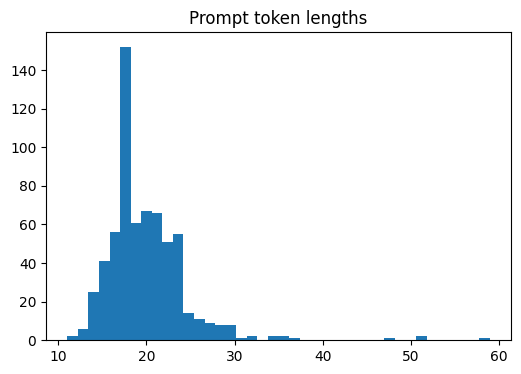

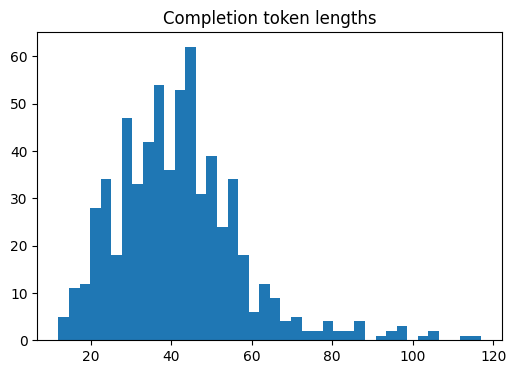

Prompt mean/p95: 19.8 27.0
Completion mean/p95: 41.9 68.9
Total p95: 91.9


In [6]:
# Token length histograms (helps choose MAX_LEN)
import numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer

DATA_JSONL = "/content/qa_clean_hr.jsonl"
BASE = "facebook/opt-1.3b"
tok = AutoTokenizer.from_pretrained(BASE, use_fast=True)
if tok.pad_token is None: tok.pad_token = tok.eos_token

ds = load_dataset("json", data_files=DATA_JSONL, split="train")
def tlen(s): return len(tok(s, add_special_tokens=False)["input_ids"])
p_l = [tlen(r["prompt"]) for r in ds]
c_l = [tlen(r["completion"]) for r in ds]

plt.figure(figsize=(6,4)); plt.hist(p_l, bins=40); plt.title("Prompt token lengths"); plt.show()
plt.figure(figsize=(6,4)); plt.hist(c_l, bins=40); plt.title("Completion token lengths"); plt.show()

print("Prompt mean/p95:", round(np.mean(p_l),1), round(np.percentile(p_l,95),1))
print("Completion mean/p95:", round(np.mean(c_l),1), round(np.percentile(c_l,95),1))
print("Total p95:", round(np.percentile([a+b for a,b in zip(p_l,c_l)],95),1))


In [3]:

print(hr_chat("How often is the company policy reviewed and updated?", mode="topp"))

The company policy is reviewed annually and updated as necessary to maintain compliance with current laws and industry standards.
